# Co-editors

This page focuses on co-editorship, especially of edited volumes, in the *Bibliographie*.   

In [5]:
# === Imports === 

import re 
import seaborn as sns
from matplotlib import pyplot as plt
from os.path import join, abspath, normpath, realpath
import os
from lxml import etree
from io import StringIO, BytesIO
from collections import Counter
import pandas as pd
import netgraph
import numpy as np
from IPython.display import HTML, display   
import networkx as nx
from pyvis.network import Network 
import matplotlib.pyplot as plt


# === Namespaces === 

namespaces = {
    "foaf" : "http://xmlns.com/foaf/0.1/",
    "bib" : "http://purl.org/net/biblio#",
    "dc" : "http://purl.org/dc/elements/1.1/",
    "z" : "http://www.zotero.org/namespaces/export#",
    "rdf" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    }


# === Files and parameters === 

wdir = join("/", "media", "christof", "Data", "Github", "christofs", "BIB18")
bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_2024-01-02.rdf") 
#bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_TEST.rdf") 
#graphviz_file = join(wdir, "figures", "collaboration_coeditors-network.svg") 


# === Load the dataset === 

def read_xml(bibdatafile): 
    bibdata = etree.parse(bibdatafile)
    return bibdata

bibdata = read_xml(bibdatafile)


## Collecting all publications that have editors

For the time being, only books (including editions) and book sections are considered. Multiple entries of the same edited volume are taken into account only once. This avoids an undue inflation of the number of cases of co-editorship in cases where multiple chapters from the same edited volume are present in the database. 

In [40]:
def get_editordata(bibdata): 
    """
    Collects data on the titles and editors of all collected volumes for which the dataset includes book sections (like chapters).
    Simplifies the data to just unique titles of collected volumes with their editors.
    """
    # Find all instances of book chapters or book sections
    xpath = "//bib:BookSection"
    sections = bibdata.xpath(xpath, namespaces=namespaces)
    print("There are " + str(len(sections)) +  " instances of element 'BookSection'.")

    # Also, find all instances of books mentioned as a whole and that have editors. 
    xpath = "/rdf:RDF/bib:Book"
    books = bibdata.xpath(xpath, namespaces=namespaces)
    print("There are " + str(len(books)) +  " instances of element 'book'.")
    sections.extend(books)
    print("Overall, there are", len(sections), "publications included at this point.")

    # For each section (and each book), get the editor(s) and booktitle
    editordata = {}
    counter = 0
    for item in sections[:]: 
        counter +=1
        xpath = ".//bib:editors//foaf:surname//text()"
        editors = item.xpath(xpath, namespaces=namespaces)
        editors = [editor for editor in editors if "lacollaborationde" not in editor]
        xpath = ".//bib:Book/dc:title//text()"
        try: 
            booktitle = item.xpath(xpath, namespaces=namespaces)[0]
        except: 
            booktitle = "missing title number " + str(counter)
            #print(booktitle) # Only happens less than 10 times, it seems. 
        # Collect each booktitle only once; only last occurrence is kept (!)
        if len(editors) > 0: 
            editordata[booktitle] = editors
    # Check results 
    #print("All of the book sections mentioned above correspond to (only)", len(editordata), "different titles of edited volumes.")
    #ratio = np.round(np.divide(len(sections), len(editordata)),2)
    #print("This means that, on average, an edited volume is mentioned", ratio, "times, each mention corresponding to one section of the volume being mentioned.")

    #for title,editors in editordata.items(): 
    #    print(editors,title)
    return editordata
editordata = get_editordata(bibdata)

There are 14421 instances of element 'BookSection'.
There are 23059 instances of element 'book'.
Overall, there are 37480 publications included at this point.


Note that many of the books don't have editors, because they are monographs. Also, many book sections correspond to different chapters from the same edited volume. Whenever that is the case, the books without editor are discarded and each edited volume is only considered once, in the next step. The total number of publications considered for the co-editor analysis is therefore substantially lower. 


## Prevalence of co-editor numbers 

Based on the data on book titles that have one or several editors, we can now investigate the prevalence of the different numbers of editors books typically have. The following table shows this data. 

In [42]:
def get_coeditor_numbers(editordata): 
    """
    Based on the editordata, establish the number of times each number of co-editors appears, 
    as well as the corresponding percentages for each number of co-editors. 
    """
    coeditors = Counter([len(item) for item in editordata.values()])
    coeditors = pd.DataFrame(pd.Series(coeditors, name="count"))
    #coeditors.drop(0, axis=0, inplace=True)

    coeditors["percentage"] = np.round(np.multiply(np.divide(coeditors["count"], np.sum(coeditors["count"])),100),1)
    # Prettify the DataFrame
    coeditors["number"] = coeditors.index
    coeditors = coeditors.sort_values(by="number")
    coeditors = coeditors[['number', 'count', 'percentage']]
    display(HTML(coeditors.to_html(index=False)))
    return coeditors
coeditors = get_coeditor_numbers(editordata)

number,count,percentage
1,2690,39.2
2,2867,41.8
3,973,14.2
4,271,3.9
5,55,0.8
6,6,0.1
10,1,0.0


The following visualization shows counts and percentages for different numbers of co-editors.

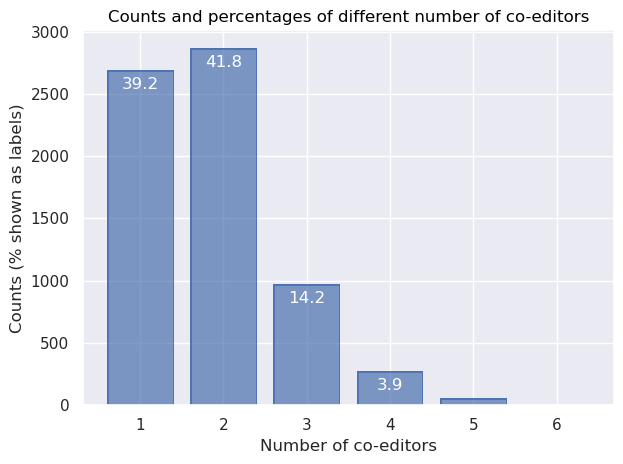

In [43]:
def visualize_coeditor_numbers(coeditors): 
    """
    Create a simple bar plot that shows 
    the percentage of each number of co-editors in the dataset.
    """

    coeditors = coeditors.iloc[:-1,:]
    import seaborn.objects as so
    (
        so.Plot(data=coeditors, x="number", y="count", text="percentage")
        .add(so.Bar())
        .add(so.Text(color="w", valign="top", offset=5))
        .scale(x=so.Continuous().tick(every=1))
        .label(
            x="Number of co-editors",
            y="Counts (% shown as labels)",
            title = "Counts and percentages of different number of co-editors")
        .save("figures/coeditor-percentages.png", dpi=300)
        .show()
    )
visualize_coeditor_numbers(coeditors)

Compared with the data on co-authorship (of books, articles and chapters), the figure above shows that co-editorship works quite differently. Indeed, when looking at editorship (of edited volumes or editions), joint editorship with two editors is the most common case (with almost 42% of the cases). Single editorship, however, is only slighly less widespread (at 39%). Triple co-editorship is also not uncommon, though clearly at a much lower level (at around 14%). 

It could be interesting to distinguish between editorship of edited volumes on the one hand, and textual editions, on the other hand. This is future work, because the dataset does not distinguish these two publication types at the moment. 

## Coeditor pairs

This section looks at which people have frequently collaborated as editors of edited volumes and/or editions. The table below shows the 10 most active pairs of editors.


In [50]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def get_recurring_coeditors(editordata): 
    """
    Which people have frequently collaborated as editors? 
    This is based on the data collected above (editors of unique titles). 
    """

    # Define filenames for output. 
    coeditorcounts_top_file = join(wdir, "results", "coeditor-counts_top.csv")
    coeditorcounts_full_file = join(wdir, "results", "coeditor-counts_full.csv")

    # Get editor names from editordata. 
    coeditors = editordata.values()
    print("Overall,", len(coeditors), "publications with editors are considered here.")

    # Establish the count of each collaboration between editors
    import itertools 
    all_coeditor_combinations = []
    for item in coeditors: 
        coeditor_combinations = list(itertools.combinations(item, 2))
        coeditor_combinations = [tuple(sorted(item)) for item in coeditor_combinations]
        for coedcomb in coeditor_combinations: 
            all_coeditor_combinations.append(coedcomb)
    ccc = dict(Counter(all_coeditor_combinations)) # ccc = coeditor_combinations_count

    # Transform to a DataFrame
    ccc = pd.DataFrame.from_dict(ccc, orient="index", columns=["count"])
    ccc = ccc.reset_index()
    ccc_split = pd.DataFrame(ccc["index"].tolist())
    ccc_merged = ccc_split.merge(ccc, left_index=True, right_index=True)
    ccc = ccc_merged.drop(["index"], axis=1)
    ccc = ccc.rename({0 : "coeditor1", 1 : "coeditor2"}, axis=1)
    ccc = ccc.sort_values(by="count", ascending=False)
    #print(ccc.head())
    #print(ccc.shape, "shape of dataframe")
    with open(join(coeditorcounts_full_file), "w", encoding="utf8") as outfile: 
        ccc.to_csv(outfile, sep=";")

    # Filter the DataFrame to make it manageable for visualization
    # Determine the top N most frequent co-editors
    coeditors_top = list(set(list(ccc.head(30).loc[:,"coeditor1"]) +\
        list(ccc.head(30).loc[:,"coeditor2"])))
    #print(coeditors_top)
    print("Among all editors, " + str(len(coeditors_top)) + " have been selected as the most active co-editors.")
    print("In the following analysis, all editors they have collaborated with, however, are included.")
    # Filter the DataFrame to include just the collaborations involving at least one of the top co-editors. 
    # The resulting DataFrame will have all collaborations between the top co-editors and their co-editors. 
    ccc_filtered = ccc[(ccc["coeditor1"].isin(coeditors_top)) |\
                       (ccc["coeditor2"].isin(coeditors_top))]
    #print(ccc_filtered.shape, "shape of dataframe of top co-editors and their co-editors.")
    # Simplify the labels 
    #ccc_filtered = ccc_filtered.replace(' .*?]', '',regex=True).astype(str)
    ccc_filtered.loc[:,'coeditor1'] =  [re.sub(r', .*','', str(x)) for x in ccc_filtered.loc[:,'coeditor1']]
    ccc_filtered.loc[:,'coeditor2'] =  [re.sub(r', .*','', str(x)) for x in ccc_filtered.loc[:,'coeditor2']]

    # Display this as a formatted table    
    display(HTML(ccc_filtered.head(10).to_html(index=False)))

    with open(join(coeditorcounts_top_file), "w", encoding="utf8") as outfile: 
        ccc_filtered.to_csv(outfile, sep=";")
    return ccc_filtered

ccc_filtered = get_recurring_coeditors(editordata)

Overall, 6863 publications with editors are considered here.
Among all editors, 44 have been selected as the most active co-editors.
In the following analysis, all editors they have collaborated with, however, are included.


coeditor1,coeditor2,count
Herman,Pelckmans,24
Hasquin,Mortier,18
Biard,Leuwers,12
Biard,Bourdin,11
Berchtold,Porret,9
Lüsebrink,Mix,8
Peeters,Pelckmans,8
Bourdin,Leuwers,8
Herman,Peeters,8
Didier,Neefs,7


## Co-editor network

Based on the frequency of co-editorships, it is possible to draw a network representation. 

The network visualization shows the editors as nodes, with their weighted degree determining the node size (the more publications they have edited with together with someone else, the larger the node). And it shows the intensity of their collaboration as the edges, with the number of coedited volumes determining the edge thickness (the more publications two editors have collaborated on, the thicker the line between them). The network layout aims to show groups of people who belong to a sub-network of co-editors who, as a group, work together frequently. 

In [91]:
def create_plot(ccc_filtered): 
    """ 
    Plot the co-editor data as a network using pyvis. 
    """
    # Prepare the dataset
    ccc = ccc_filtered
    ccc.rename(columns={"count": "weight"}, inplace=True)
    ccc = ccc[ccc["weight"] > 0] # for filtering, with "0", all items remain

    # Load the data into a NetworkX graph
    net = Network('1600px', '2800px', notebook=True, cdn_resources='in_line')
    G = nx.Graph()
    for line in ccc.iterrows(): 
        G.add_edge(line[1][0], line[1][1], weight=line[1][2], title=line[1][2])
    degrees = dict(G.degree)
    degrees.update((x, ((y*10)**0.5)) for x, y in degrees.items())
    nx.set_node_attributes(G, degrees, 'size')
    print(G)
    
    # Plot the data using pyvis
    net.from_nx(G)
    net.toggle_physics(True)
    net.show("figures/coeditor-network.html")
    return G, degrees
G, degrees = create_plot(ccc_filtered)


Graph with 308 nodes and 367 edges
figures/coeditor-network.html


This data can be visualized as a network. Click on the following image for an interactive network plot. 

[![coeditor network](figures/coeditor-network_dummy.png)](figures/coeditor-network.html) 

The visualization shows, like the tabular display, that Herman and Pelckmans (with 24 co-edited volumes the collaborated on!) and Hasquins and Mortier (with 18 edited volumes) are the most intense collaborators in terms of co-editorship. 

More interestingly, however, the network visualisation shows that there are multiple, independent co-editor networks. Some of them are loosely connected between each other, others are entirely disconnected from the main network. And some co-editors serve as connections between several sub-networks, like Sermain connecting the sub-networks of Didier-Neefs, Berchtold and Herman-Pelckmans with each other (the latter two being only indirectly connected, otherwise). Chartier connecting the sub-networks Martin on the one hand, Lüsebrink-Mix on the other. 

## An additional look at the graph data

Based on the data modeled as a graph, we can not only visualize it, but also extract some additional information. For example, the total number of co-editorships a given person has engaged in determines their 'degree' in the network. This data is already used in the visualization to determine various node sizes, but the people with the highest degrees can be shown here separately as well. 


In [92]:
def check_degrees(degrees): 
    # Reverse the scaling from the visualization
    degrees.update((x, ((y**2)/10)) for x, y in degrees.items())
    degrees = pd.DataFrame.from_dict(degrees, orient="index", columns=["degree"])
    degrees["coeditor"] = degrees.index
    degrees = degrees[["coeditor", "degree"]]
    degrees.sort_values(by="degree", ascending=False, inplace=True)
    # Display this as a formatted table    
    display(HTML(degrees.head(10).to_html(index=False)))


check_degrees(degrees)
    

coeditor,degree
Martin,49.0
Bourdin,24.0
Lüsebrink,23.0
Porret,22.0
Berchtold,21.0
Leuwers,17.0
Herman,16.0
Biard,14.0
Rosset,13.0
Barbier,13.0


This essentially shows that, while some editors _pairs_ have worked together particularly frequently (think Herman and Pelckman or Hasquin and Mortier above), they are not necessarily the ones who have engaged in the most co-editorships overall. Martin is clearly the person who has engaged in the most co-editor relationships (i.e., cumulated number of co-editors involved in all volumes he co-edited).   


## For comparison: Gephi visualization

See the [collaborations](collaborations.html) page. – NB! Note that the analysis and visualizations there are currently based on the data before reduction to unique book titles. 